# End-to-End Data Cleaning Pipeline with Raha and Baran (Minimal and Integrated)
We build an end-to-end data cleaning pipeline with our configuration-free error detection and correction systems, Raha and Baran.

In [1]:
import pandas
import IPython.display
import ipywidgets

import raha

## 1. Instantiating the Detection and Correction Classes
We first instantiate the `Detection` and `Correction` classes.

In [2]:
from raha import analysis_utilities
app_1 = raha.Detection()
app_2 = raha.Correction()

# How many tuples would you label?
app_1.LABELING_BUDGET = 20
app_2.LABELING_BUDGET = 0

# Would you like to see the logs?
app_1.VERBOSE = True
app_2.VERBOSE = True

## 2. Instantiating the Dataset
We next load and instantiate the dataset object.

In [3]:
dataset_dictionary = {
        "name": "flights",
        "path": "datasets/flights/dirty.csv",
        "clean_path": "datasets/flights/clean.csv"
    }
d = app_1.initialize_dataset(dataset_dictionary)
d.dataframe.head()

,tuple_id,src,flight,sched_dep_time,act_dep_time,sched_arr_time,act_arr_time
0,1,aa,AA-3859-IAH-ORD,7:10 a.m.,7:16 a.m.,9:40 a.m.,9:32 a.m.
1,2,aa,AA-1733-ORD-PHX,7:45 p.m.,7:58 p.m.,10:30 p.m.,
2,3,aa,AA-1640-MIA-MCO,6:30 p.m.,,7:25 p.m.,
3,4,aa,AA-518-MIA-JFK,6:40 a.m.,6:54 a.m.,9:25 a.m.,9:28 a.m.
4,5,aa,AA-3756-ORD-SLC,12:15 p.m.,12:41 p.m.,2:45 p.m.,2:50 p.m.


## 3. Generating Features and Clusters
Raha runs (all or the promising) error detection strategies on the dataset. This step could take a while because all the strategies should be run on the dataset. Raha then generates a feature vector for each data cell based on the output of error detection strategies. Raha next builds a hierarchical clustering model for our clustering-based sampling approach.

In [4]:
app_1.run_strategies(d)
app_1.generate_features(d)
app_1.build_clusters(d)

I just load strategies' results as they have already been run on the dataset!


309 strategy profiles are collected.
40 Features are generated for column 0.
65 Features are generated for column 1.
62 Features are generated for column 2.
65 Features are generated for column 3.
71 Features are generated for column 4.
65 Features are generated for column 5.
86 Features are generated for column 6.
A hierarchical clustering model is built for column 0.
A hierarchical clustering model is built for column 1.
A hierarchical clustering model is built for column 2.
A hierarchical clustering model is built for column 3.
A hierarchical clustering model is built for column 4.
A hierarchical clustering model is built for column 5.
A hierarchical clustering model is built for column 6.


## 4. Interactive Tuple Sampling and Labeling
Raha then iteratively samples a tuple. We should label data cells of each sampled tuple.

In [5]:
# def on_button_clicked(_):
#     for j in range(0, len(texts)):
#         cell = (d.sampled_tuple, j)
#         error_label = 0
#         correction = texts[j].value
#         if d.dataframe.iloc[cell] != correction:
#             error_label = 1
#         d.labeled_cells[cell] = [error_label, correction]
#     d.labeled_tuples[d.sampled_tuple] = 1
#
# app_1.sample_tuple(d)
# print("Fix the dirty cells in the following sampled tuple.")
# sampled_tuple = pandas.DataFrame(data=[d.dataframe.iloc[d.sampled_tuple, :]], columns=d.dataframe.columns)
# IPython.display.display(sampled_tuple)
# texts = [ipywidgets.Text(value=d.dataframe.iloc[d.sampled_tuple, j]) for j in range(d.dataframe.shape[1])]
# button = ipywidgets.Button(description="Save the Annotation")
# button.on_click(on_button_clicked)
# output = ipywidgets.VBox(children=texts + [button])
# IPython.display.display(output)

For the sake of time, we use the ground truth of the dataset to label tuples below.

In [6]:
%%capture
while len(d.labeled_tuples) < app_1.LABELING_BUDGET:
    app_1.sample_tuple(d)
    if d.has_ground_truth:
        app_1.label_with_ground_truth(d)

## 5. Propagating User Labels and Predicting the Labels
Raha then propagates each user label through its cluster. Raha then trains and applies one classifier per data column to predict the label of the rest of data cells.

In [7]:
app_1.propagate_labels(d)
app_1.predict_labels(d)

The number of labeled data cells increased from 140 to 13032.
A classifier is trained and applied on column 0.
A classifier is trained and applied on column 1.
A classifier is trained and applied on column 2.
A classifier is trained and applied on column 3.
A classifier is trained and applied on column 4.
A classifier is trained and applied on column 5.
A classifier is trained and applied on column 6.


## 6. Initializing and Updating the Error Corrector Models
Baran initializes the error corrector models. Baran then iteratively samples a tuple. We should label data cells of each sampled tuple. It then udpates the models accordingly and generates a feature vector for each pair of a data error and a correction candidate. Finally, it trains and applies a classifier to each data column to predict the final correction of each data error. Since we already labeled tuples for Raha, we use the same labeled tuples and do not label new tuples here.

In [8]:
app_2.initialize_models(d)
app_2.initialize_dataset(d)
for si in d.labeled_tuples:
    d.sampled_tuple = si
    app_2.update_models(d)
    app_2.generate_features(d)
    app_2.predict_corrections(d)

The error corrector models are initialized.
The error corrector models are updated with new labeled tuple 385.
472729 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 3: Train
    Column 4: Train
    Column 5: Train
    Column 6: Train
Train sizes in this step:
    Column 3: 768
    Column 4: 872
    Column 5: 1719
    Column 6: 2288
Corrections applied in this step:
    Column 3: 876 Real changes: 876
    Column 4: 698 Real changes: 698
    Column 5: 907 Real changes: 907
    Column 6: 689 Real changes: 689
70% (3167 / 4550) of data errors are corrected.
The error corrector models are updated with new labeled tuple 2166.
478042 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 3: Train
    Column 4: Train
    Column 5: Train
    Column 6: Train
Train sizes in this step:
    Column 3: 774
    Column 4: 891
    Column 5: 1726
    Column 6: 2310
Corrections applied in this s

## 7. Storing Results
Both Raha and Baran can also store the error detection/correction results.

In [9]:
app_1.store_results(d)
app_2.store_results(d)

The results are stored in datasets/flights/raha-baran-results-flights/error-detection/detection.dataset.
The results are stored in datasets/flights/raha-baran-results-flights/error-correction/correction.dataset.


## 8. Evaluating the Data Cleaning Task
We can finally evaluate our data cleaning task.

In [10]:
edp, edr, edf = d.get_data_cleaning_evaluation(d.detected_cells)[:3]
ecp, ecr, ecf = d.get_data_cleaning_evaluation(d.corrected_cells)[-3:]

evaluation_df = pandas.DataFrame(columns=["Task", "Precision", "Recall", "F1 Score"])
evaluation_df = evaluation_df.append({"Task": "Error Detection (Raha)", "Precision": "{:.2f}".format(edp), 
                                      "Recall": "{:.2f}".format(edr), "F1 Score": "{:.2f}".format(edf)}, ignore_index=True)
evaluation_df = evaluation_df.append({"Task": "Error Correction (Baran)", "Precision": "{:.2f}".format(ecp), 
                                      "Recall": "{:.2f}".format(ecr), "F1 Score": "{:.2f}".format(ecf)}, ignore_index=True)
evaluation_df.head()

/home/adrian/source/MA/raha/raha/dataset.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if correction_dictionary[cell] == actual_errors[cell]:


,Task,Precision,Recall,F1 Score
0,Error Detection (Raha),0.89,0.82,0.85
1,Error Correction (Baran),0.84,0.59,0.69


In [11]:
import importlib
importlib.reload(analysis_utilities)
import matplotlib.pyplot as plt
plt.style.use('seaborn')


In [12]:
actual_errors = d.get_actual_errors_dictionary()

Histograms of the probabilities of the detection algorithm by (label, true label)


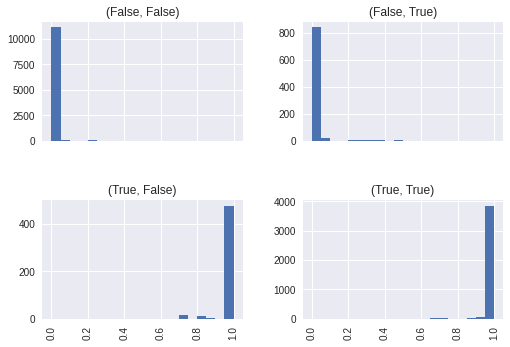

In [13]:
analysis_utilities.detection_evaluation(d, actual_errors)

In [14]:
correction_confidence_df = analysis_utilities.get_correction_confidence_df(d, actual_errors)

In [15]:
correction_confidence_df.shape[0]

3435

In [16]:
(correction_confidence_df["confidence"] < 0.98).sum()

240

Distribution of confidences for wrong (False) and correct (True) corrections:


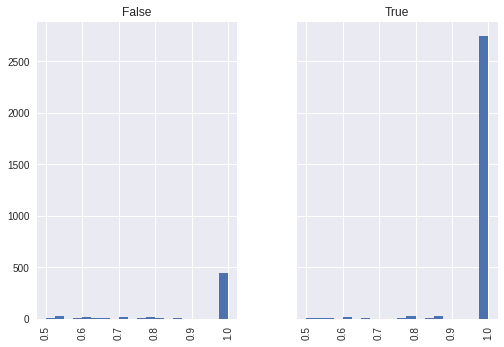

In [17]:
analysis_utilities.correction_confidence_distributions(correction_confidence_df)

Empirical probability of a correction being wrong given its confidence:


<ipython-input-18-6f5863a60e14>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


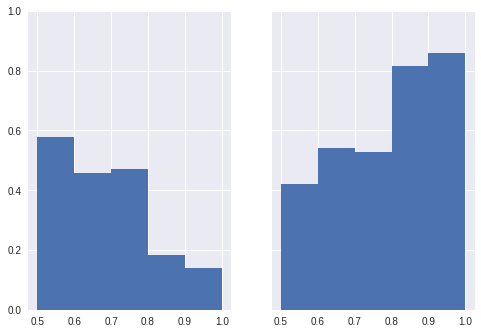

In [18]:
f = analysis_utilities.correction_correctness_by_confidence(correction_confidence_df)
f.show()

In [19]:
print(analysis_utilities.result_analysis(d.dataframe, d.corrected_cells))

Changed attributes: [(3, 'sched_dep_time'), (4, 'act_dep_time'), (5, 'sched_arr_time'), (6, 'act_arr_time')]
Number of changed cells: 3435
Number of changed tuples: 1593
% of tuples changed: 67.05All changes:
       row  column value_before value_after    type_before     type_after  \
0      184       3               11:45 a.m.  <class 'str'>  <class 'str'>   
1      784       3                7:35 a.m.  <class 'str'>  <class 'str'>   
2     1243       3               10:45 a.m.  <class 'str'>  <class 'str'>   
3     1287       3                9:00 p.m.  <class 'str'>  <class 'str'>   
4     1504       3                8:15 a.m.  <class 'str'>  <class 'str'>   
...    ...     ...          ...         ...            ...            ...   
3430  1775       4    8:12 a.m.   8:12 a.m.  <class 'str'>  <class 'str'>   
3431  1875       4    8:12 a.m.   8:12 a.m.  <class 'str'>  <class 'str'>   
3432  1967       4    8:26 a.m.   8:12 a.m.  <class 'str'>  <class 'str'>   
3433  2067       4   

In [20]:
import pandas_profiling

In [24]:
profile = pandas_profiling.ProfileReport(d.dataframe, title="Pandas Profiling Report"explorative=True)

In [25]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
df = d.create_repaired_dataset(d.corrected_cells)
df

In [31]:
profile2 = pandas_profiling.ProfileReport(d.repaired_dataframe, title="After Clean Report", explorative=True)
profile2.to_widgets()

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]